# 1. Understanding The Problem

Before we begin coding, we first need to understand what is the problem we are looking at. In order to do that we need to first:
- Understand the business context.
- What are our goals and objectives.
- What is the domain hypotheses for the problem.
- Understand what are our baselines (if we have any).
- Understand and plan what are the metrics for evaluation which we wish to use.

These understandings are crucial to save time and address the real issue while getting the full picture of things before we even start to code.

## 1.1. Business Context

WellCo is an employer-sponsored digital health ecosystem focused on preventing cardiometabolic disease through digital engagement.

## 1.2. Objectives

1. Predict and rank members by likelihood of churn.
2. Determine optimal outreach size 'n' that maximizes retention benefit given constant outreach cost.

## 1.3. Domain Hypotheses

- Members engaging more frequently with nutrition, excercise, sleep and midfulness content are less likely to churn.
- Lack of recent app or web activity is a strong churn signal.
- Certain clinical profiles (e.g., E11.9, I10) may have distinct churn patterns tied to care adherence.

## 1.4. Baseline Summary 

A baseline performance metrtics was provided as reference points for model improvement.
The files provided were as follows:
1) auc_baseline.txt which contains the ROC-AUC baseline.
2) classification_report_baseline.txt which contains the following metrics: accuracy, precision, recall, F1, Macro F1 and weighted F1.

- ROC-AUC = 0.501
- Accuracy = 0.50
- Precision (churn) = 0.20
- Recall (churn) = 0.51
- F1 (churn) = 0.29
- Macro F1 = 0.45
- Weighted F1 = 0.55

## 1.5. Baseline Interpretation

- The baseline AUC is approximately 0.5 which indicates no discriminative power - The model performs like random guessing.
- Precision/Recall asymmetry shows strong bias toward predicting non-churn, consistent with a class imbalance (approximately 20% churners).
- This creates a clear opportunity to improve through:
    - Feature engineering (engagement frequency, recency, claim activity).
    - Balanced training (class weighting, stratified sampling).
    - More robust models (tree ensembles, calibrated probabilities).

## 1.6. Evaluation

To assess model performance, we will:
- Use ROC-AUC as the primary metric to evaluate ranking quality.
- Track precision@k, recall@k, and lift charts for top deciles to measure business impact.
- Validate using stratified k-fold cross validation to handle class imbalance.
- Compare results directly to the provided baseline metrics.

# 2. Data Exploration & Integration

This notebook combines data exploartion and feature engineering into a single worklow.<br>
The goal is to iteratively explore each data source (app usage, web visits, claims, and churn labels), create meaningful behavioral and clinical features, assess their quality (missigness, distributions, correlations), and prepare a clean, consolidated dataset for modeling.

## 2.1. Imports & I/O

We will start by importing the relevant libraries for this part and load the datasets from the provided "data" directory.

In [ ]:
import pandas as pd
from pathlib import Path
from src.helpers import (categorize_visit, compute_obs_end, add_recency_from_last, assert_integrity, impute_with_flags)
from src.visualization import plot_churn_by_quantile, plot_top_corrs

In [2]:
DATA = Path("data")
web = pd.read_csv(DATA/"web_visits.csv", parse_dates=["timestamp"])
app = pd.read_csv(DATA/"app_usage.csv", parse_dates=["timestamp"])
claims = pd.read_csv(DATA/"claims.csv", parse_dates=["diagnosis_date"])
labels = pd.read_csv(DATA/"churn_labels.csv", parse_dates=["signup_date"])

In [3]:
OBS_END = compute_obs_end(app["timestamp"], web["timestamp"], claims["diagnosis_date"])
print("OBS_END:", OBS_END)

OBS_END: 2025-07-14 00:00:00


## 2.2. Quick Audits

In [4]:
for name, df in {"web": web, "app": app, "claims": claims, "labels": labels}.items():
    print(name, df.shape, df.member_id.nunique())

web (259340, 5) 9975
app (97789, 3) 9998
claims (64576, 3) 9980
labels (10000, 4) 10000


## 2.3. App Features (sessions within observation window)

For the App features, we would like to look at the number of app sessions, number of app active days and the number of days since the user last interacted with the app to find out if they have any impact on churn probability.<br>
The expected behavior is that users who engage more often and more times will have a lower churn probability, as well as users who are using the app for a long period of time.

In [5]:
app["date"] = app["timestamp"].dt.date
app_agg = app.groupby("member_id").agg(
    app_sessions=("timestamp", "count"),
    app_active_days=("date", "nunique"),
    app_last_seen=("timestamp", "max")
)
app_agg["app_days_since_last"] = add_recency_from_last(app_agg["app_last_seen"], OBS_END)

## 2.4. Web Features (content categories + engagement)

For the web features, we would like to get the categories of content in the websites to see what is the most common content and what category users is more likely to churn.

In [6]:
web["categories"] = web.apply(
    lambda r: categorize_visit(r.get("url", ""), r.get("title", ""), r.get("description", "")), axis=1)

In [7]:
web["date"] = web["timestamp"].dt.date
web_all = web.groupby("member_id").agg(
    web_visits = ("timestamp", "count"),
    web_activity_days = ("date", "nunique"),
    web_unique_titles = ("title", "nunique"),
    web_last_seen = ("timestamp", "max")
)
web_all["web_days_since_last"] = add_recency_from_last(web_all["web_last_seen"], OBS_END)

In [8]:
expected_cats = ["nutrition", "activity", "sleep", "stress", "other"]
web_cat_long = (
    web.loc[:, ["member_id", "categories"]]
       .explode("categories")
       .dropna(subset=["categories"])
)

In [9]:
web_cat_counts = (
    web_cat_long
      .groupby(["member_id", "categories"])
      .size()
      .unstack(fill_value=0)
)

In [10]:
for c in expected_cats:
    if c not in web_cat_counts.columns:
        web_cat_counts[c] = 0
web_cat_counts = web_cat_counts[expected_cats]

In [11]:
den = web_all["web_visits"].replace(0, pd.NA)
web_cat_props = web_cat_counts.div(den, axis=0)
web_cat_props = web_cat_props.fillna(0.0)
web_cat_props.columns = [f"{c}_share" for c in web_cat_props.columns]

In [12]:
web_cat_any = (web_cat_counts > 0).astype(int)
web_cat_any.columns = [f"{c}_any" for c in web_cat_any.columns]

In [13]:
web_all = (
    web_all.join(web_cat_counts, how="left")
           .join(web_cat_props,  how="left")
           .join(web_cat_any,    how="left")
           .fillna(0)
)

In [14]:
print("Joined category columns:",
      [c for c in web_all.columns if c in expected_cats or c.endswith(("_share","_any"))][:10], "...")
print(web_all.shape)

Joined category columns: ['nutrition', 'activity', 'sleep', 'stress', 'other', 'nutrition_share', 'activity_share', 'sleep_share', 'stress_share', 'other_share'] ...
(9975, 20)


## 2.5. Claims Features (ICD Flags + utilization)

For claims we would like to count the number of ICDs per member and the number of distinct ICDs per members as well as the number of days since last diagnosis.<br>
We would like to see if recently diagnosed members are more likely to churn or maybe veteran members are more likely to churn.<br>
Also, we would like to check if the number of distinct diagnoses affect on the member's likelihood to churn.

We will start by getting the relevant counts per member as described.

In [15]:
claims_agg = claims.groupby("member_id").agg(
    claims_count = ("icd_code", "count"),
    claims_distinct_icd = ("icd_code", "nunique"),
    last_dx = ("diagnosis_date", "max")
)
claims_agg["days_since_last_dx"] = add_recency_from_last(claims_agg["last_dx"], OBS_END)

In [16]:
unique_icds = claims["icd_code"].unique()
print(unique_icds)

['Z71.3' 'J00' 'M54.5' 'I10' 'E11.9' 'K21.9' 'R51' 'A09' 'B34.9' 'H10.9']


We will check how many ICDs each member has on average to see how many ICDs we would like to mark as the top icds and continue with them.

In [17]:
claims_per_member = claims.groupby("member_id")["icd_code"].nunique()
print(claims_per_member.describe())

count    9980.000000
mean        4.662325
std         1.550630
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        10.000000
Name: icd_code, dtype: float64


In [18]:
icd_member_presence = (
    claims.drop_duplicates(["member_id", "icd_code"])
          .assign(flag=1)
          .groupby("icd_code")["flag"]
          .mean()
          .sort_values(ascending=False)
)

In [19]:
top_k = 5
top_icds = icd_member_presence.head(top_k).index.tolist()
print("Top ICDs:", top_icds)

# pivot flags ONLY for top-5
claims_flags_top = (
    claims[claims["icd_code"].isin(top_icds)]
        .drop_duplicates(["member_id", "icd_code"])
        .assign(flag=1)
        .pivot_table(index="member_id", columns="icd_code", values="flag", aggfunc="max", fill_value=0)
)

Top ICDs: ['A09', 'B34.9', 'E11.9', 'H10.9', 'I10']


We can see that the top 5 icds are A09, B34.9, E11.9, H10.9, I10.

In [20]:
claims_flags_top.columns = [f"icd_{c.replace('.', '_')}" for c in claims_flags_top.columns]

In [21]:
other_icd = (
    claims[~claims["icd_code"].isin(top_icds)]
        .drop_duplicates(["member_id", "icd_code"])
        .assign(flag=1)
        .groupby("member_id")["flag"].max()
        .rename("icd_other")
)

In [22]:
claims_flags = claims_flags_top.join(other_icd, how="outer").fillna(0).astype(int).reset_index()

In [23]:
claims_feat = claims_agg.merge(claims_flags, on="member_id", how="left").fillna(0)

In [24]:
print("icd_other prevalence:", claims_feat["icd_other"].mean())
print("sample flags:", [c for c in claims_feat.columns if c.startswith("icd_")][:10])

icd_other prevalence: 0.9495991983967936
sample flags: ['icd_A09', 'icd_B34_9', 'icd_E11_9', 'icd_H10_9', 'icd_I10', 'icd_other']


In [25]:
only_top = (
    claims.groupby("member_id")["icd_code"]
          .apply(lambda x: set(x).issubset(set(top_icds)))
          .mean()
)
print(f"Fraction of members with only top ICDs: {only_top:.3f}")

Fraction of members with only top ICDs: 0.050


After we analyze members diagnosis patterns to determine how many ICD code flags to include, we can see that:
- On average, each member had approximately 4.7 unique ICDs with a the median being 5.
- Only about 5% of members had diagnoses entirely within the top 5 ICDs.

This indicates that most members have multiple distinct diagnoses outside the most common codes, making the 'icd_other' flag nearly constant and therefore non-informative.<br>
We selected the top-5 ICDs as binary indicators and dropped 'icd_other' to reduce noise and avoid adding features with no variance.

In [26]:
claims_feat.drop(columns=["icd_other"], inplace=True)

## 2.6. Labels & Tenure

In this part we will enrich the labels table by adding a new feature - 'tenure_days'.
- The labels dataset already includes each member's signup_date and churn indicator, but to better understand member lifecycle behavior, we calculate how long each member has been active in the system up to the end of the observation period ('OBS_END').
- 'tenure_days' is computed as the number of days between 'OBS_END' and each members 'signup_date'.

This feature provides valuable context for churn modeling:
- It helps distinguish new members (short tenure) from long-standing ones (long tenure).
- It allows normalization of other time-dependent activity features in later analyses.

We would expect the tenure days to have high correlation with member churn probability as we would expect longer tenure members who were consistent to remain that way and be less likely to churn. On the other hand, short tenure members are probably adjusting to the new routines and not always manage to stay consistent and the assumption would be that they are more likely to churn as changing routines is not a simple task.

In [27]:
labels["tenure_days"] = (OBS_END - labels["signup_date"]).dt.days

## 2.7. Merge

In [28]:
features = (labels
            .merge(app_agg, on="member_id", how="left")
            .merge(web_all, on="member_id", how="left")
            .merge(claims_feat, on="member_id", how="left")
            )

In [29]:
assert_integrity(features, OBS_END)

In [30]:
cols_to_drop = [c for c in ["web_last_seen", "app_last_seen", "last_dx", "signup_date"]
                if c in features.columns]
features = features.drop(columns=cols_to_drop)

In [31]:
cat_bases     = ["nutrition","activity","sleep","stress","other"]
cat_counts    = [c for c in cat_bases if c in features.columns]          # integers
cat_any       = [f"{c}_any" for c in cat_bases if f"{c}_any" in features.columns]  # binaries
cat_shares    = [f"{c}_share" for c in cat_bases if f"{c}_share" in features.columns]  # ratios

In [32]:
# Impute
count_cols = [
    "app_sessions", "app_active_days", "web_visits", "web_activity_days", "web_unique_titles",
    "claims_count", "claims_distinct_icd"
]

recency_cols = ["app_days_since_last", "web_days_since_last", "days_since_last_dx"]
binary_cols  = ["icd_A09", "icd_B34_9", "icd_E11_9", "icd_H10_9", "icd_I10"]
cat_any_cols = [f"{c}_any" for c in cat_bases if f"{c}_any"   in features.columns]
tenure_cols  = ["tenure_days"]

In [33]:
count_cols  += cat_counts
binary_cols += cat_any

In [34]:
features = impute_with_flags(features, count_cols, recency_cols, binary_cols, tenure_cols)

In [35]:
if cat_shares:
    features[cat_shares] = features[cat_shares].fillna(0.0)

In [36]:
features["share_residual"] = 0.0
m = features["web_visits"] > 0
features.loc[m, "share_residual"] = (1.0 - features.loc[m, cat_shares].sum(axis=1)).clip(lower=0.0)

In [37]:
mask = features["web_visits"] > 0
print("Avg |sum(shares)-1| (visits>0):",
      (features.loc[mask, cat_shares].sum(axis=1) - 1.0).abs().mean())
assert features[cat_shares + ["share_residual"]].isnull().sum().sum() == 0

Avg |sum(shares)-1| (visits>0): 0.043409502667506664


We use category shares as composition features. Because visits can match multiple categories and some members have no web activity, shares don't strictly sum to 1. This is intentional: models can learn from non-normalized compositions. We adda a 'share_residual' term to capture any leftover mass.<br>
For tree models we keep all shares.<br>
For linear models we can drop one share to avoid collinearity.

## 2.8. Training Cohort (contol-only to avoid treatment leakage)

To prevent the model from learning patterns that are influenced by members who received outreach interventions, we restrict training data to the control group (outreach == 0).<br>
We then split this control subset into an 80/20 train-holdout split for internal validation and final evaluation.<br>
This ensures that the model is trained only on natural, unbiased behavior and that its performance is evaluated on clean, non-intervened data.

In [38]:
train_ctrl = features.query("outreach == 0").copy()
holdout_ctrl = train_ctrl.sample(frac=0.2, random_state=42)
train_ctrl = train_ctrl.drop(holdout_ctrl.index)

## 2.9. Basic EDA readouts

In [39]:
print(f"Churn rate(all): {features['churn'].mean().round(3)}")
print(f"Churn rate (control): {train_ctrl['churn'].mean().round(3)}")
nulls = features.isnull().mean().sort_values(ascending=False).head(20)
print(f"Top null rates:\n{nulls}")

Churn rate(all): 0.202
Churn rate (control): 0.211
Top null rates:
member_id              0.0
churn                  0.0
outreach               0.0
tenure_days            0.0
app_sessions           0.0
app_active_days        0.0
app_days_since_last    0.0
web_visits             0.0
web_activity_days      0.0
web_unique_titles      0.0
web_days_since_last    0.0
nutrition              0.0
activity               0.0
sleep                  0.0
stress                 0.0
other                  0.0
nutrition_share        0.0
activity_share         0.0
sleep_share            0.0
stress_share           0.0
dtype: float64


We can see that we managed to impute the data so we don't have any null values in it.

## 2.11. Data Profiling

In this part, we will assess missing data rates, outliers, and overall feature distribution to determine if any columns should be dropped or flagged before modeling.

In [40]:
drop_threshold = 0.3
drop_candidates = nulls[nulls > drop_threshold].index.tolist()
print(f"Columns with >{drop_threshold*100:.0f}% missing: {drop_candidates}")

Columns with >30% missing: []


Columns with over 30% missing will be considered for removal unless business-critical.
Columns with moderate missingness (5–30%) will be imputed and flagged.

## 2.12. Exploratory Analysis

Now that we confirmed data quality, we will explore which variables appear most predictive of churn.

In [41]:
target = "churn"
numeric_cols = features.select_dtypes("number").columns.drop(["member_id"])

We will first check the correlation for the numeric cols with the target column 'churn'.

In [42]:
corrs = features[numeric_cols].corrwith(features[target]).sort_values(key=abs, ascending=False)
display(corrs)

churn                  1.000000
other_share            0.150702
tenure_days           -0.137206
activity_share        -0.090064
nutrition_share       -0.083487
app_sessions          -0.078680
app_active_days       -0.076883
activity              -0.076436
stress_share          -0.074400
nutrition             -0.071403
stress_any            -0.061516
stress                -0.060501
sleep_share           -0.055792
sleep                 -0.055553
activity_any          -0.054849
web_unique_titles     -0.050363
nutrition_any         -0.047911
other                  0.043619
icd_I10               -0.038848
sleep_any             -0.038039
claims_count          -0.022455
icd_E11_9             -0.022438
other_any              0.020592
icd_A09                0.017953
share_residual        -0.016701
outreach              -0.016362
web_days_since_last   -0.015233
claims_distinct_icd   -0.013019
app_days_since_last    0.011482
days_since_last_dx     0.010802
web_visits             0.003213
icd_B34_

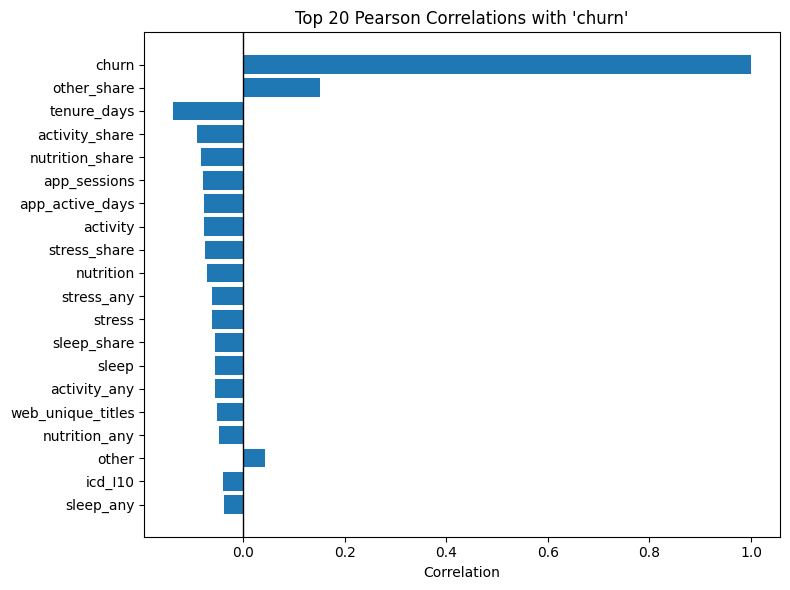

In [43]:
fig, ax, corrs = plot_top_corrs(features, numeric_cols, target="churn", method="pearson", top_n=20)


### 2.12.1 Correlation Insights

Out correlation analysis reveals several interesting patterns related to churn behavior:
- Tenure days show the strongest negative correlation (approximately -0.14), suggesting that longer-term members are less likely to churn.
- Content share variables stand out: members with higher "other_share" have a positive correlation (approximately +0.15) with churn, while those engaging more with activity, nutrition, and stress content show negative correlations (-0.07 to -0.09).
- Engagement frequency metrics such a s app_sessions and app_active_days also exhibit negative correlations (approximately -0.08), indicating that more frequent app use is linked to higher retention.
- Clinical indicators (e.g. ICD flags) and claims related variables display smaller negative relationships, implying limited linear impact but possible value in more complex patterns.
- Recency related features have minimal correlations, which is expected since they mainly capture inactivity timing rather than enagement intensity.

Overall, these findings suggest that churn risk increases when members shift their attention away from core wellness content and interact less frequently with the platform, while consistent engagement and longer tenure remain strong retention factors.

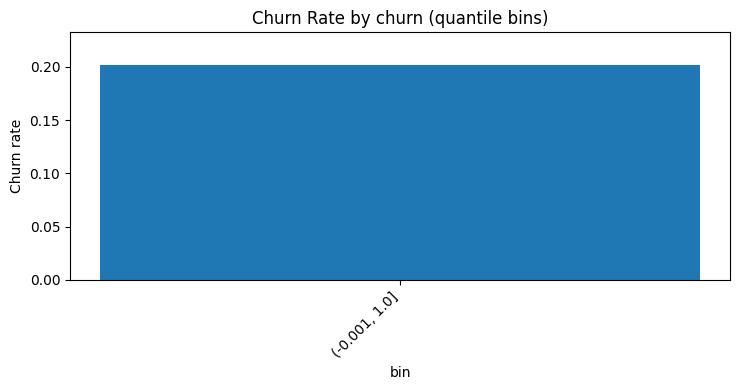

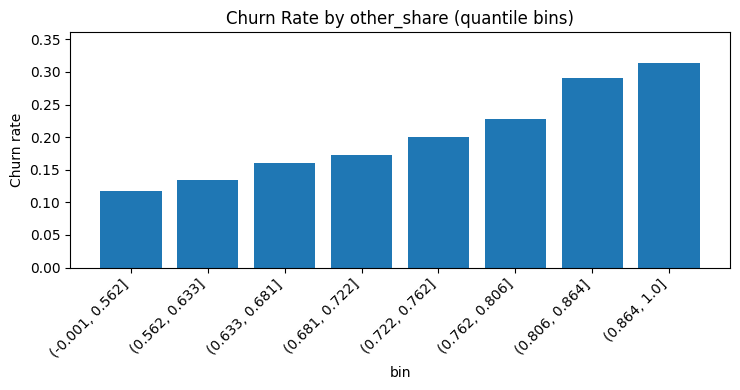

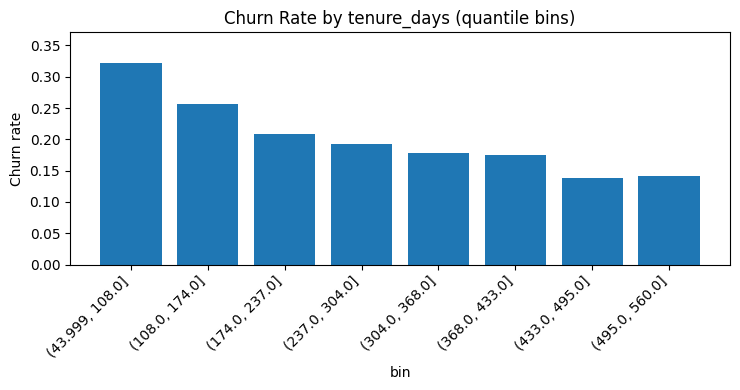

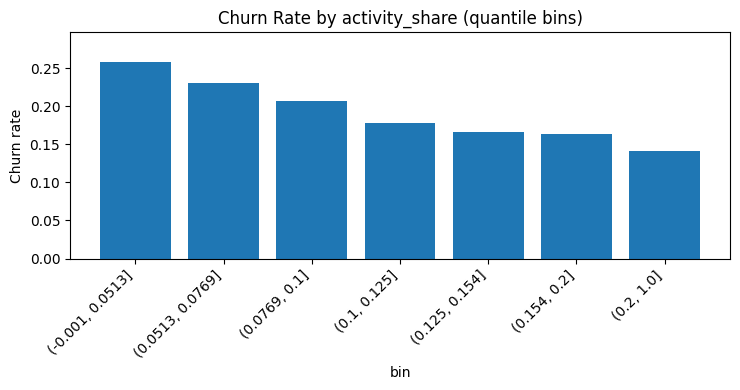

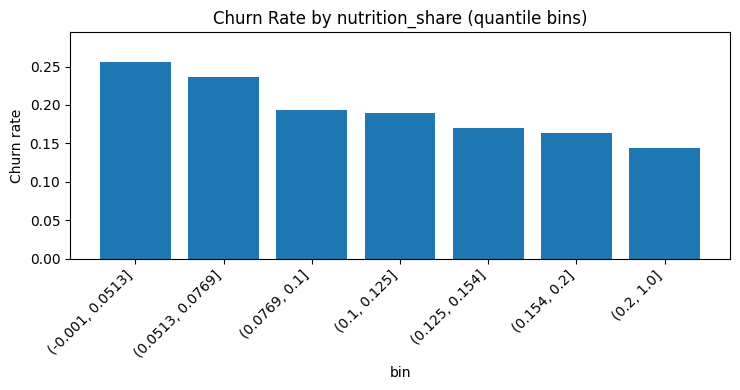

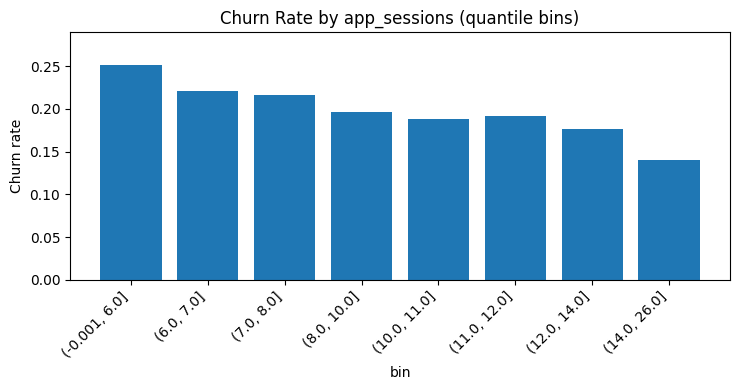

In [44]:
top_feats = corrs.head(6).index.tolist()
for f in top_feats:
    plot_churn_by_quantile(features, f, target="churn", bins=8, strategy="quantile", min_bin_size=30)

Since the 'corrwith' function uses Pearson to measure linear relationships, we will also check using Spearman method which measures monotonic relationships.<br> 
Spearman method detects any consistent trend, even nonlinear ones. 

In [45]:
features[numeric_cols].corrwith(features["churn"], method="spearman").sort_values()

tenure_days           -0.137183
activity_share        -0.100352
nutrition_share       -0.095175
activity              -0.079949
app_sessions          -0.077119
stress_share          -0.077073
nutrition             -0.075720
app_active_days       -0.074018
stress                -0.069584
stress_any            -0.061516
activity_any          -0.054849
web_unique_titles     -0.053849
sleep_share           -0.053031
sleep                 -0.052191
nutrition_any         -0.047911
icd_I10               -0.038848
sleep_any             -0.038039
claims_count          -0.024506
icd_E11_9             -0.022438
claims_distinct_icd   -0.017256
share_residual        -0.016701
outreach              -0.016362
web_activity_days     -0.005170
days_since_last_dx    -0.003473
icd_B34_9             -0.003140
icd_H10_9             -0.001785
web_visits            -0.000309
web_days_since_last    0.002757
icd_A09                0.017953
other_any              0.020592
app_days_since_last    0.030983
other   

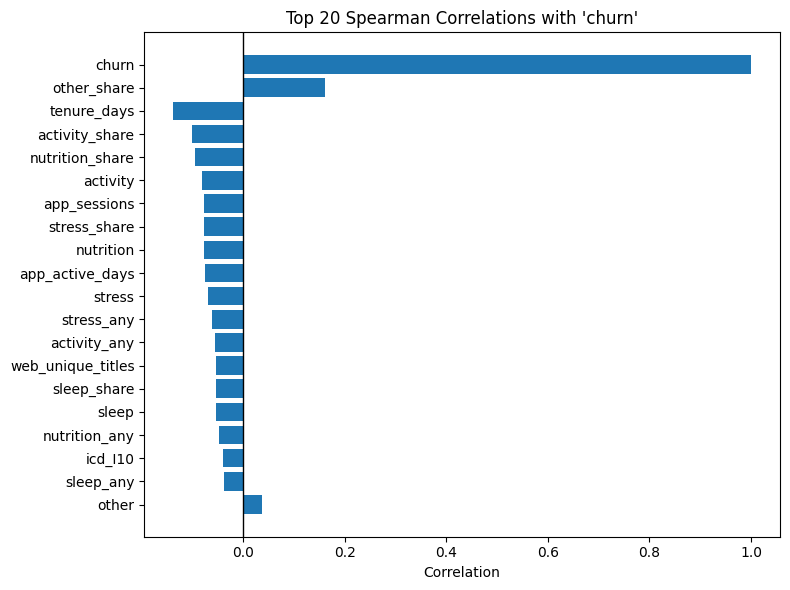

In [46]:
fig, ax, corrs = plot_top_corrs(features, numeric_cols, target="churn", method="spearman", top_n=20)

### 2.12.2. Spearman Correlation Insights

The results of using the Spearman method confirm the overall consistency of the relationships.
- Tenure days remains the strongest predictor with a negative correlation (approxiamtely −0.14), reinforcing that longer membership duration lowers churn risk.
- Engagement shares for activity, nutrition, and stress all show negative monotonic trends (−0.07 to −0.10), indicating that higher engagement across these areas steadily reduces churn probability.
- App-based activity metrics (e.g., app_sessions, app_active_days) continue to exhibit moderate negative correlations (approximately −0.08), confirming that more frequent usage is linked with stronger retention.
- Other_share still shows a small positive monotonic correlation (approximately +0.16), suggesting that when a larger proportion of engagement shifts toward non-core content, churn likelihood slightly increases.
- Recency and claims-related features show minimal correlations, suggesting limited monotonic relationships with churn.

Overall, the Spearman analysis supports the same behavioral insights as Pearson: higher engagement, focused activity, and longer tenure are the main retention drivers, while shifts in engagement patterns or lower platform activity are early churn signals.

## 2.13. Save Intermediate

In [48]:
Path("artifacts").mkdir(exist_ok=True)
features.to_parquet("artifacts/features_merged.parquet", index=False)
train_ctrl.to_parquet("artifacts/train_control.parquet", index=False)
holdout_ctrl.to_parquet("artifacts/holdout_control.parquet", index=False)